In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, random
import tqdm  # for showing loading animation
import cv2
import matplotlib.pyplot as plt

### EDA

In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/ML_Projects/HEALTHCARE/ODR/full_df.csv')
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [6]:
len(df['Left-Diagnostic Keywords'].unique())

196

In [7]:
(df['Left-Diagnostic Keywords'] == 'cataract').sum()

268

In [8]:
def has_cataract(text):
  return 1 if 'cataract' in text else 0

df['left_cataract'] = df['Left-Diagnostic Keywords'].apply(lambda x: has_cataract(x))
df['right_cataract'] = df['Right-Diagnostic Keywords'].apply(lambda x: has_cataract(x))

## Cataract Images

In [9]:
# Arrays of cataract images
left_cataract = df.loc[(df.left_cataract == 1),'Left-Fundus']
right_cataract = df.loc[(df.right_cataract == 1),'Right-Fundus']

In [10]:
print(f"Count of left cataract images : {len(left_cataract)}")
print(f"Count of right cataract images : {len(right_cataract)}")

Count of left cataract images : 304
Count of right cataract images : 290


## Normal Images

In [11]:
# Arrays of normal images of size ~ equal to size of cataract (here 300)
left_normal = df.loc[(df['Left-Diagnostic Keywords'] == 'normal fundus'),'Left-Fundus'].sample(300,random_state=42).values
right_normal = df.loc[(df['Right-Diagnostic Keywords'] == 'normal fundus'),'Right-Fundus'].sample(300,random_state=42).values

In [12]:
left_normal[:10]

array(['3205_left.jpg', '3156_left.jpg', '2549_left.jpg', '3365_left.jpg',
       '2537_left.jpg', '82_left.jpg', '2597_left.jpg', '2508_left.jpg',
       '3245_left.jpg', '4245_left.jpg'], dtype=object)

In [13]:
# concatenation
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [14]:
# create dataset
dir_path = '/content/gdrive/MyDrive/ML_Projects/HEALTHCARE/ODR/preprocessed_images'
image_size = 224
dataset = []
labels = []
def create_dataset(image_category,label):
  for img_name in image_category:
    img_path = os.path.join(dir_path,img_name)
    try:
      image = cv2.imread(img_path,cv2.IMREAD_COLOR)
      image = cv2.resize(image,(image_size,image_size))
    except:
      continue
    dataset.append([np.array(image),np.array(label)])

  random.shuffle(dataset)
  return dataset

In [15]:
dataset = create_dataset(cataract,1)

In [16]:
len(dataset)

588

In [17]:
dataset = create_dataset(normal,0)

In [18]:
len(dataset)

1188

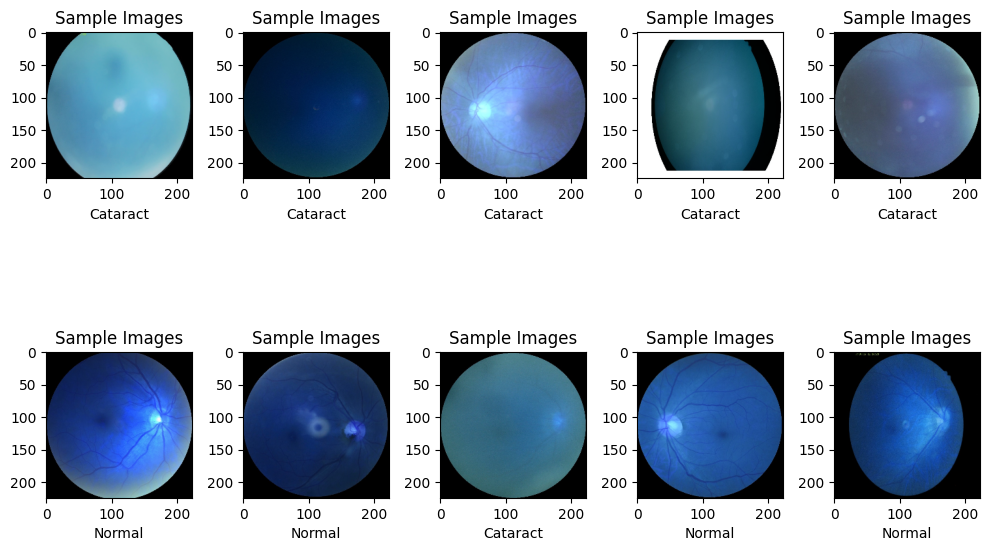

In [76]:
plt.figure(figsize=(10,7))
for i in range(10):
  sample = random.choice(range(len(dataset)))
  img = dataset[sample][0]
  category = dataset[sample][1]
  label = "Cataract" if category == 1 else "Normal"
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.title("Sample Images")
  plt.xlabel(label)

plt.tight_layout()

### Dividing the dataset

In [20]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42,test_size=0.25)

In [22]:
# check the normal distribution of dataset
pd.DataFrame(y_train).value_counts(normalize=True)

0    0.505051
1    0.494949
dtype: float64

In [41]:
pd.DataFrame(y_test).value_counts(normalize=True)

0    0.505051
1    0.494949
dtype: float64

### Creating model

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential

In [25]:
from keras.applications.vgg16 import VGG16, preprocess_input
vgg16_weight_path = "/content/gdrive/MyDrive/ML_Projects/HEALTHCARE/ODR/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

vgg = VGG16(include_top=False, weights=vgg16_weight_path,input_shape=(224,224,3))

In [26]:
# for layer in vgg.layers:
#   layer.trainable = False

# above means the same as below

vgg.trainable = False

In [27]:
model = Sequential()
model.add(vgg)
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense (Dense)               (None, 7, 7, 256)         131328    
                                                                 
 dropout (Dropout)           (None, 7, 7, 256)         0         
                                                                 
 dense_1 (Dense)             (None, 7, 7, 128)         32896     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 dense_2 (Dense)             (None, 7, 7, 64)          8256      
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 64)          0

In [29]:
# Define a custom metric function for F1 score
# For a balance between precision and recall
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    f1 = 2 * tf.reduce_sum(tf.math.multiply(y_true, y_pred)) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))
    return f1

In [30]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [50]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
28/28 [==============================] - 6s 202ms/step - loss: 0.0695 - accuracy: 0.9787 - val_loss: 0.1353 - val_accuracy: 0.9461
Epoch 2/10
28/28 [==============================] - 5s 192ms/step - loss: 0.0538 - accuracy: 0.9798 - val_loss: 0.1075 - val_accuracy: 0.9663
Epoch 3/10
28/28 [==============================] - 5s 197ms/step - loss: 0.0383 - accuracy: 0.9865 - val_loss: 0.0797 - val_accuracy: 0.9764
Epoch 4/10
28/28 [==============================] - 5s 197ms/step - loss: 0.0278 - accuracy: 0.9921 - val_loss: 0.0705 - val_accuracy: 0.9764
Epoch 5/10
28/28 [==============================] - 5s 194ms/step - loss: 0.0164 - accuracy: 0.9966 - val_loss: 0.0808 - val_accuracy: 0.9764
Epoch 6/10
28/28 [==============================] - 5s 192ms/step - loss: 0.0104 - accuracy: 0.9989 - val_loss: 0.0785 - val_accuracy: 0.9764
Epoch 7/10
28/28 [==============================] - 5s 188ms/step - loss: 0.0087 - accuracy: 0.9989 - val_loss: 0.0808 - val_accuracy: 0.9697
Epoch 

In [51]:
loss , accuracy = model.evaluate(x_test,y_test)

10/10 [==============================] - 1s 116ms/step - loss: 0.0935 - accuracy: 0.9764


In [52]:
print(loss)
print(accuracy)

0.09347201883792877
0.9764309525489807


In [57]:
model.save('/content/gdrive/MyDrive/ML_Projects/HEALTHCARE/ODR/models/cataract_detection_model.h5')

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred1 = model.predict(x_test)
y_pred = np.argmax(y_pred1, axis=1)

10/10 [==============================] - 1s 117ms/step


In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       150
           1       0.00      0.00      0.00       147

    accuracy                           0.51       297
   macro avg       0.25      0.50      0.34       297
weighted avg       0.26      0.51      0.34       297



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
clf = model
pred_test = model.predict(x_test)

for i in range(len(pred_test)):
  pred_test[i] = 1 if pred_test[i] > 0.5 else 0


10/10 [==============================] - 1s 117ms/step


In [65]:
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, mean_absolute_error

precision = precision_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test)
recall = recall_score(y_test, pred_test)
accuracy = accuracy_score(y_test, pred_test)

print(f"Precision Score = {precision}")
print(f"F1-score = {f1}")
print(f"Recall Score = {recall}")
print(f"Accuracy Score = {accuracy}")

Precision Score = 0.9794520547945206
F1-score = 0.9761092150170648
Recall Score = 0.9727891156462585
Accuracy Score = 0.9764309764309764


In [70]:
!pip install scikit-plot

In [71]:
from scikitplot.metrics import plot_confusion_matrix

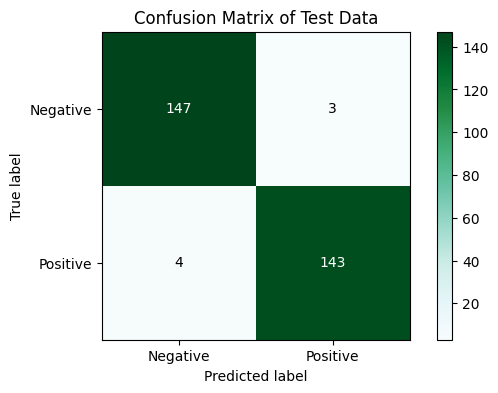

In [73]:
q = y_test

pred_test = pd.DataFrame(pred_test)
y_test = pd.DataFrame(y_test)

pred_test = pred_test.replace([0,1],["Negative","Positive"])
y_test = y_test.replace([0,1],["Negative","Positive"])

plot_confusion_matrix(y_test, pred_test, figsize=(7,4), title='Test Data - Confusion Matrix', cmap='BuGn')

y_test = q